In [17]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.stats import t
import matplotlib.pyplot as plt

**(d) (30 puntos)**

En el mercado, el **VaR** y el **ES** son las medidas populares para medir el riesgo de una cartera o un activo, sin embargo, es común ver que usan _rolling windows_, i.e. fijar una ventana de $X$ días y con esos datos calcular el $VaR$ o $ES$ del día $X + 1$, ejemplo: con una ventana de 252 retornos $(r_1, r_2, ..., r_{252})$ calculas el $VaR_\alpha$ asociado al retorno $r_{253}$, ahora el $VaR_\alpha$ asociado al retorno $r_{254}$ viene del conjunto de datos $(r_2, r_3, ..., r_{253})$, etc.



Con esto en mente, **en una sola gráfica muestra las ganancias y pérdidas además del $VaR$ y el $ES$ con $\alpha = 0.95$ y $0.99$ con una _rolling window_ de 252 retornos** (debe de ser una serie de tiempo) y **sobre todo recuerda que el $VaR_\alpha^{t}$ es calculado con los retornos $r_1, r_2, ..., r_{252}$ y busca predecir el retorno $r_{253}$, y el $VaR_\alpha^{t+1}$ calculado con los retornos $r_2, r_3, ..., r_{253}$ busca predecir el retorno $r_{254}$, etc.**



**Asegúrate que tu código realice esta gráfica además de ponerla en el Streamlit.**  
La estimación del $VaR$ y $ES$ debe de ser **histórico y paramétrico** (puedes asumir una distribución normal por practicidad), recuerda el ejemplo que se vio en clase.

In [18]:
# ------------------------------------------
# 1. PARÁMETROS DE CONFIGURACIÓN
# ------------------------------------------

ticker = 'AAPL'
start_date = '2010-01-01'
end_date = '2025-03-28'
window = 252
alphas = [0.95, 0.99]

# ------------------------------------------
# 2. DESCARGA DE DATOS Y CÁLCULO DE RETORNOS
# ------------------------------------------

df = yf.download(ticker, start=start_date, end=end_date)
df['returns'] = df['Close'].pct_change()
df = df.dropna()

[*********************100%***********************]  1 of 1 completed


In [19]:
# ------------------------------------------
# 3. FUNCIÓN PARA CÁLCULO PARAMÉTRICO
# ------------------------------------------

"""
def parametric_var_es(returns, alpha):


    #Calcula el VaR y el ES asumiendo distribución normal.

    mu = returns.mean()
    sigma = returns.std()
    var = norm.ppf(1 - alpha, mu, sigma)
    es = returns[returns <= var].mean()
    return var, es

"""

# Función para calcular VaR y ES usando t-Student
def parametric_var_es_tstudent(returns, alpha, nu=20):
    mu = np.mean(returns)
    s2 = np.var(returns, ddof=1)  # Varianza muestral insesgada
    sigma2 = ((nu - 2) / nu) * s2
    sigma = np.sqrt(sigma2)

    VaR = t.ppf(1 - alpha, df=nu, loc=mu, scale=sigma)
    
    def safe_quantile_mean(alpha, nu, mu, sigma, num_points=1000):
        cuantiles = t.ppf(np.linspace(1e-6, alpha-1e-6, num_points), df=nu, loc=mu, scale=sigma)
        return np.mean(cuantiles)
    ES = safe_quantile_mean(1 - alpha, nu, mu, sigma)
    return VaR, ES


def historical_es(returns, alpha):

    """
    Calcula el Expected Shortfall (ES) histórico.

    """

    var_threshold = returns.quantile(1 - alpha)
    return returns[returns <= var_threshold].mean()

# ------------------------------------------
# 4. ROLLING WINDOW PARA VAR Y ES
# ------------------------------------------

#Inicializamos el DataFrame para guardar resultados
results = pd.DataFrame(index=df.index)
results['returns'] = df['returns']

for alpha in alphas:
    #Columnas para guardar los resultados
    var_param_col = f'VaR_param_{int(alpha*100)}'
    es_param_col = f'ES_param_{int(alpha*100)}'
    var_hist_col = f'VaR_hist_{int(alpha*100)}'
    es_hist_col = f'ES_hist_{int(alpha*100)}'

        #VaR y ES paramétrico con t-Student
    results[var_param_col] = results['returns'].rolling(window).apply(
        lambda x: parametric_var_es_tstudent(x, alpha)[0], raw=False)
    results[es_param_col] = results['returns'].rolling(window).apply(
        lambda x: parametric_var_es_tstudent(x, alpha)[1], raw=False)

        #VaR histórico (percentil)
    results[var_hist_col] = results['returns'].rolling(window).quantile(1 - alpha)

        #ES histórico (percentil)
    results[es_hist_col] = results['returns'].rolling(window).apply(
        lambda x: historical_es(x, alpha), raw=False)

In [20]:
window_data = results['returns'].iloc[-252:]
var95, es95 = parametric_var_es_tstudent(window_data, 0.95, nu=5)
var99, es99 = parametric_var_es_tstudent(window_data, 0.99, nu=5)

print(f"VaR 95% (t, ν=5): {var95:.4f}")
print(f"ES  95% (t, ν=5): {es95:.4f}")
print(f"VaR 99% (t, ν=5): {var99:.4f}")
print(f"ES  99% (t, ν=5): {es99:.4f}")

VaR 95% (t, ν=5): -0.0229
ES  95% (t, ν=5): -0.0335
VaR 99% (t, ν=5): -0.0390
ES  99% (t, ν=5): -0.0521


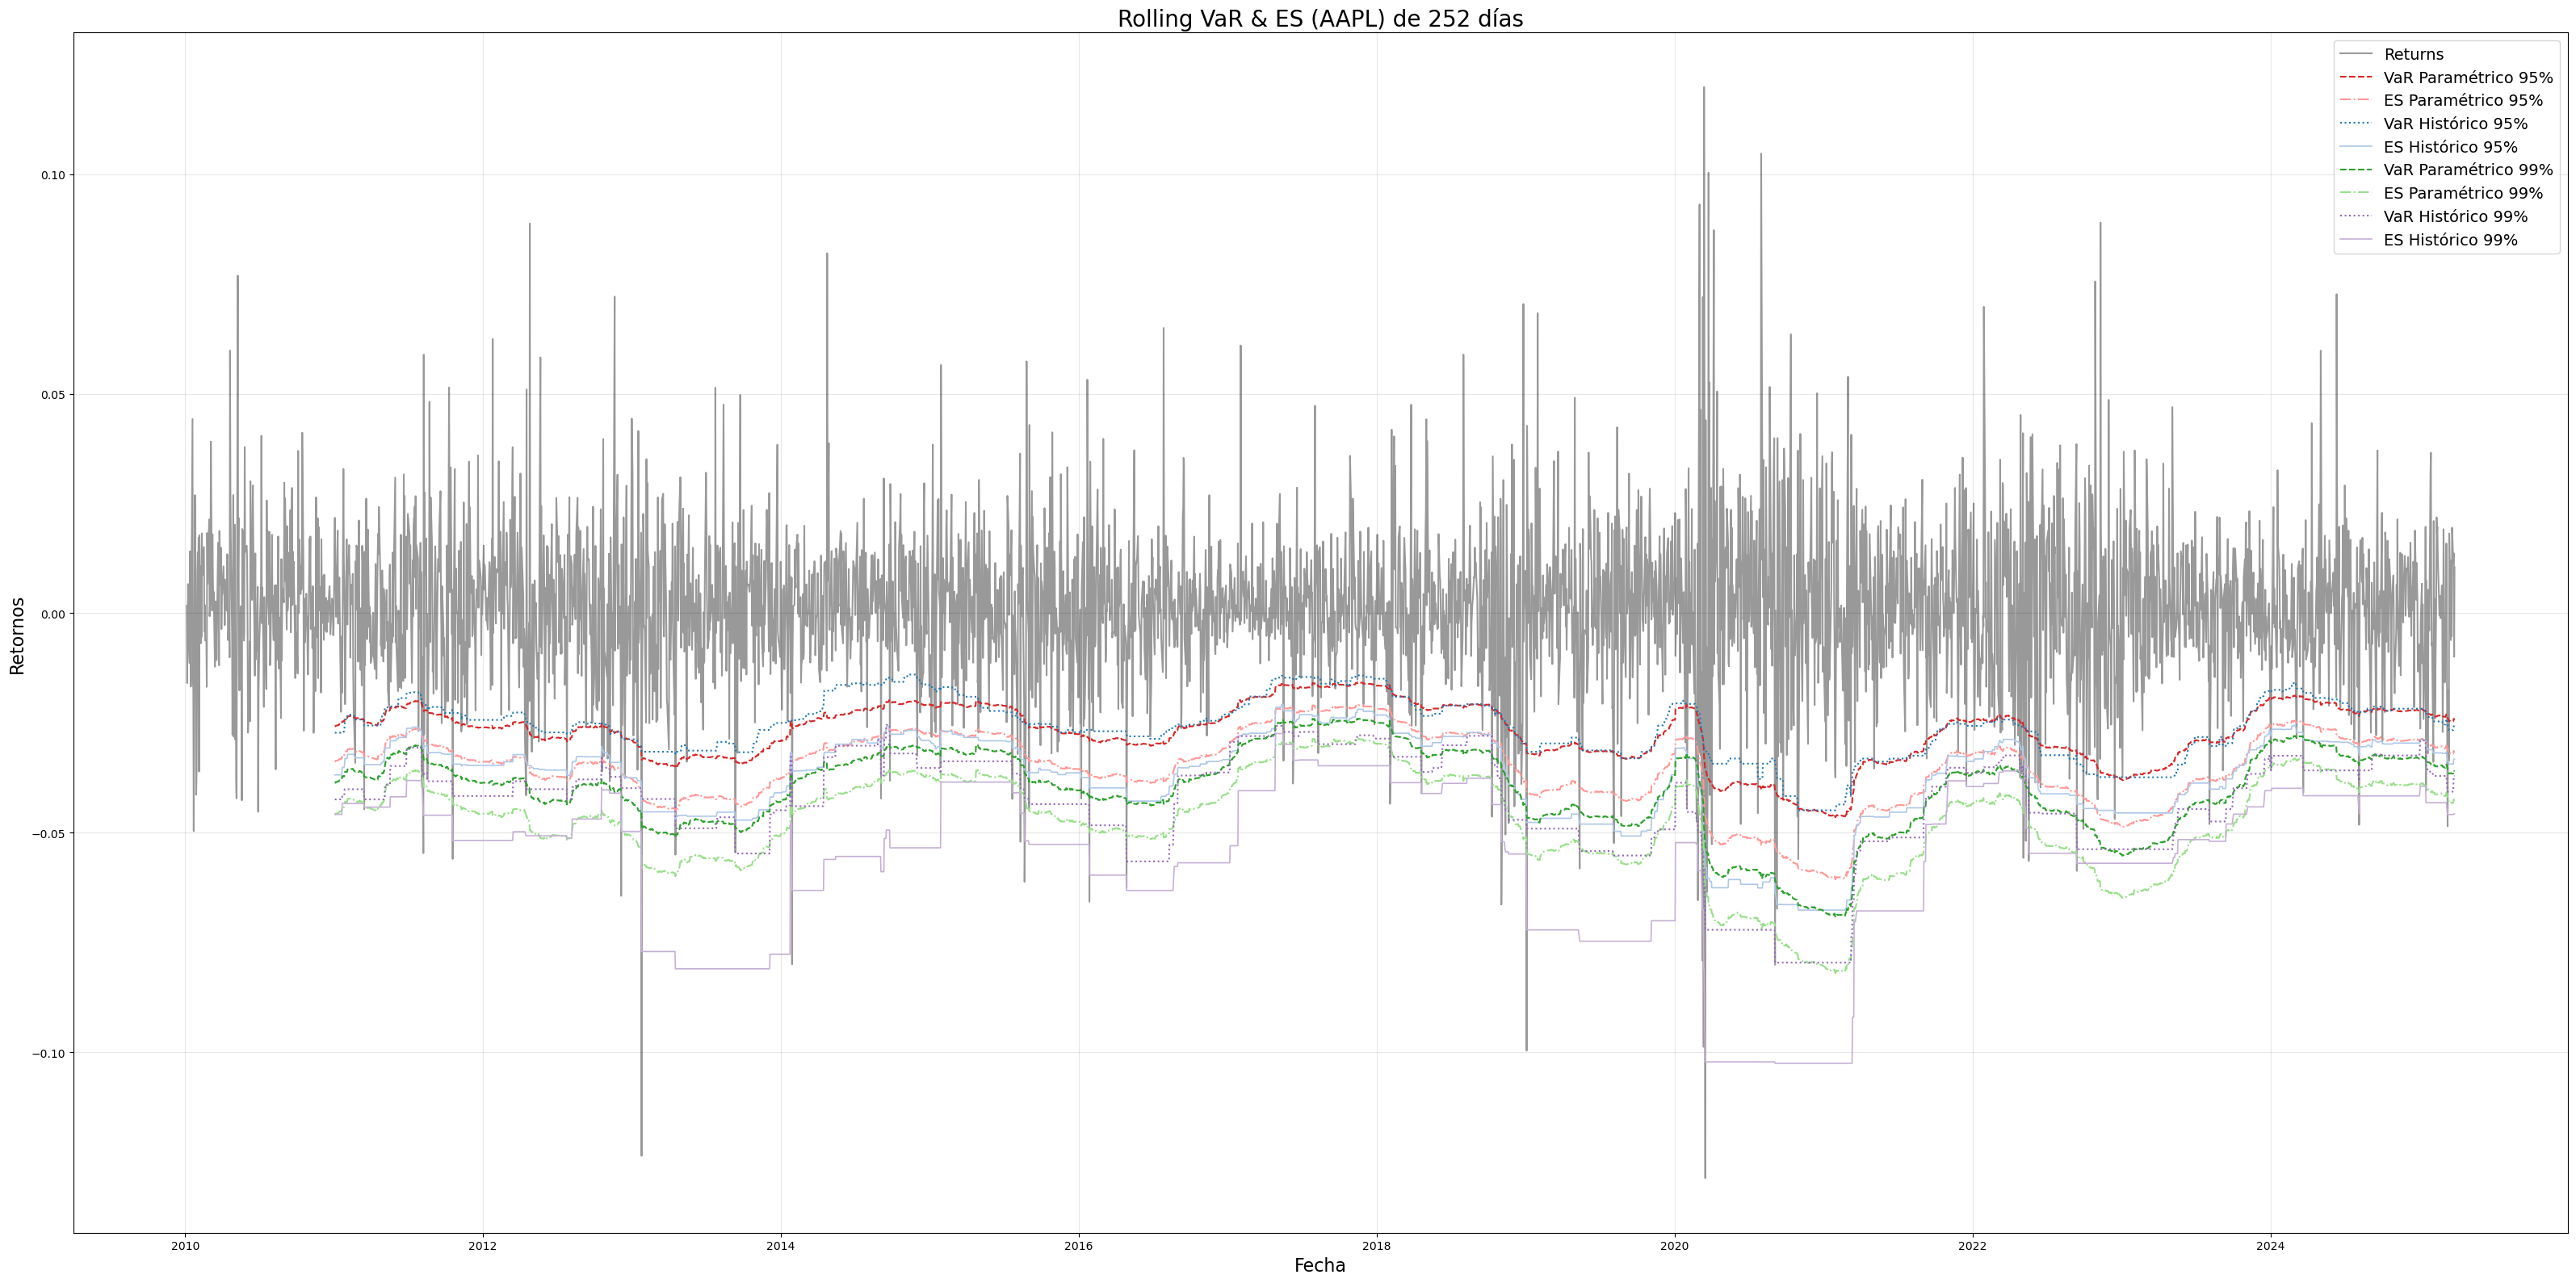

In [21]:
# ------------------------------------------
# 5. VISUALIZACIÓN EN LA GRÁFICA
# ------------------------------------------

plt.figure(figsize=(32, 16))
plt.plot(results['returns'], label='Returns', color='black', alpha=0.4)

#Colores por tipo y nivel de confianza
colors = {
    'VaR_param_95': '#d62728',    # rojo oscuro
    'ES_param_95': '#ff9896',     # rojo claro
    'VaR_hist_95': '#1f77b4',     # azul oscuro
    'ES_hist_95': '#aec7e8',      # azul claro
    'VaR_param_99': '#2ca02c',    # verde oscuro
    'ES_param_99': '#98df8a',     # verde claro
    'VaR_hist_99': '#9467bd',     # morado oscuro
    'ES_hist_99': '#c5b0d5'       # morado claro
}

#Dibujamos líneas de VaR y ES para cada nivel de confianza
for alpha in alphas:
    a = int(alpha * 100)
    plt.plot(results[f'VaR_param_{a}'], label=f'VaR Paramétrico {a}%', linestyle='--', color=colors[f'VaR_param_{a}'])
    plt.plot(results[f'ES_param_{a}'], label=f'ES Paramétrico {a}%', linestyle='-.', color=colors[f'ES_param_{a}'])
    plt.plot(results[f'VaR_hist_{a}'], label=f'VaR Histórico {a}%', linestyle=':', color=colors[f'VaR_hist_{a}'])
    plt.plot(results[f'ES_hist_{a}'], label=f'ES Histórico {a}%', linestyle='-', linewidth=1.2, color=colors[f'ES_hist_{a}'])

plt.title(f'Rolling VaR & ES ({ticker}) de 252 días', fontsize=20)
plt.xlabel('Fecha', fontsize=16)
plt.ylabel('Retornos', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

(e) (20 puntos) Finalmente, para saber la eficiencia de nuestras estimaciones calcularemos el n ́umero de
veces que la p ́erdida fue superior a la estimaci ́on usando Var o ES, i.e. Definiremos violaci ́on si

$$r_{253} < VaR^t_α \quad o \quad ES^t_α$$

donde el $VaR^t_α \quad o \quad ES^t_α$ fue calculado con los retornos $r_1, r_2, ..., r_{252}$, o si

$$r_{254} < VaR^t_α \quad o \quad ES^t_α$$

donde el $VaR^t_α \quad o \quad ES^t_α$ fue calculado con los retornos $r_2, r_3, ..., r_{253}$, etc. En una tabla reporta el n ́umero
de violaciones y como porcentaje del tama ̃no de la muestra para cada nivel de confianza y cada medida
de riesgo. Tu c ́odigo debe generar esos resultados por si solo. Nota: Una buena estimaci ́on genera
un porcentaje de violaciones menores al $2.5 \%$.

In [28]:
sum_r=[]

for col in results: #iteramos sobre cada encabezado
  #print(col)
  sum = 0
  if col != 'returns': #solo lo hacemos para los VaR y ES
    for i in range(len(results) - 1): #iteramos sobre todos los renglones
      if results[col][i]	!= np.nan: #iteramos sobre el rango de los no nulos
        if results['returns'][i+1] < results[col][i] : #comparamos si estimó bien o no
          sum += 1
    sum_r.append(sum)


sum_r=np.array(sum_r)#convertimos a arreglo de numpy

porc = (sum_r/len(results))*100 #calculamos el porcentaje de aciertos

estim = ['Buena estimación' if i < 2.5 else 'Mala estimación' for i in porc]

#Ahora creamos un dataframe que muestre el porcentaje y numero de fallos por cada VaR y ES
fallas = pd.DataFrame(
    {
        'VaR_param_95': [f'{porc[0]}%', sum_r[0], estim[0]],
        'ES_param_95': [f'{porc[1]}%', sum_r[1], estim[1]],
        'VaR_hist_95': [f'{porc[2]}%', sum_r[2], estim[2]],
        'ES_hist_95': [f'{porc[3]}%', sum_r[3], estim[3]],
        'VaR_param_99': [f'{porc[4]}%', sum_r[4], estim[4]],
        'ES_param_99': [f'{porc[5]}%', sum_r[5], estim[5]],
        'VaR_hist_99': [f'{porc[6]}%', sum_r[6], estim[6]],
        'ES_hist_99': [f'{porc[7]}%', sum_r[7], estim[7]],
    }
    , index=['Porcentaje de fallas','Número de fallas','Tipo de estimación']
)

/var/folders/p6/809xns1d35v6npj64hnx3j3w0000gn/T/ipykernel_30883/734212832.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if results[col][i]	!= np.nan: #iteramos sobre el rango de los no nulos
/var/folders/p6/809xns1d35v6npj64hnx3j3w0000gn/T/ipykernel_30883/734212832.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if results['returns'][i+1] < results[col][i] : #comparamos si estimó bien o no


In [29]:
results['returns']

Date
2010-01-05    0.001729
2010-01-06   -0.015907
2010-01-07   -0.001848
2010-01-08    0.006648
2010-01-11   -0.008821
                ...   
2025-03-21    0.019477
2025-03-24    0.011270
2025-03-25    0.013682
2025-03-26   -0.009922
2025-03-27    0.010473
Name: returns, Length: 3831, dtype: float64

In [ ]:
fallas

['Porcentaje de fallas', 'Número de fallas', 'Tipo de estimación']


In [33]:
from datetime import datetime
# Función para obtener datos
def obtener_datos(stock):
    df = yf.download(stock, start='2010-01-01', end=datetime.today().strftime('%Y-%m-%d'))['Close']
    return df

# Función para calcular rendimientos
def calcular_rendimientos(df):
    return df.pct_change().dropna()

# Función para calcular VaR y ES usando t-Student
def parametric_var_es_tstudent(returns, alpha, nu=20):
    mu = np.mean(returns)
    s2 = np.var(returns, ddof=1)  # Varianza muestral insesgada
    sigma2 = ((nu - 2) / nu) * s2
    sigma = np.sqrt(sigma2)

    VaR = t.ppf(1 - alpha, df=nu, loc=mu, scale=sigma)
    
    def safe_quantile_mean(alpha, nu, mu, sigma, num_points=1000):
        cuantiles = t.ppf(np.linspace(1e-6, alpha-1e-6, num_points), df=nu, loc=mu, scale=sigma)
        return np.mean(cuantiles)
    ES = safe_quantile_mean(1 - alpha, nu, mu, sigma)
    return VaR, ES

In [34]:
df_precios = obtener_datos('AAPL')
df_rendimientos = calcular_rendimientos(df_precios)

print(df_rendimientos)

VaR_t, ES_t = parametric_var_es_tstudent(df_rendimientos['AAPL'], alpha)
# VaR y ES Histórico
VaR_hist = df_rendimientos['AAPL'].quantile(1 - alpha)
ES_hist = df_rendimientos['AAPL'][df_rendimientos['AAPL'] <= VaR_hist].mean()

print(VaR_t)
print(ES_t)
#

[*********************100%***********************]  1 of 1 completed

Ticker          AAPL
Date                
2010-01-05  0.001729
2010-01-06 -0.015906
2010-01-07 -0.001849
2010-01-08  0.006648
2010-01-11 -0.008821
...              ...
2025-03-27  0.010473
2025-03-28 -0.026580
2025-03-31  0.019413
2025-04-01  0.004772
2025-04-02  0.003136

[3835 rows x 1 columns]
-0.04103238778295701
-0.04853532112820174


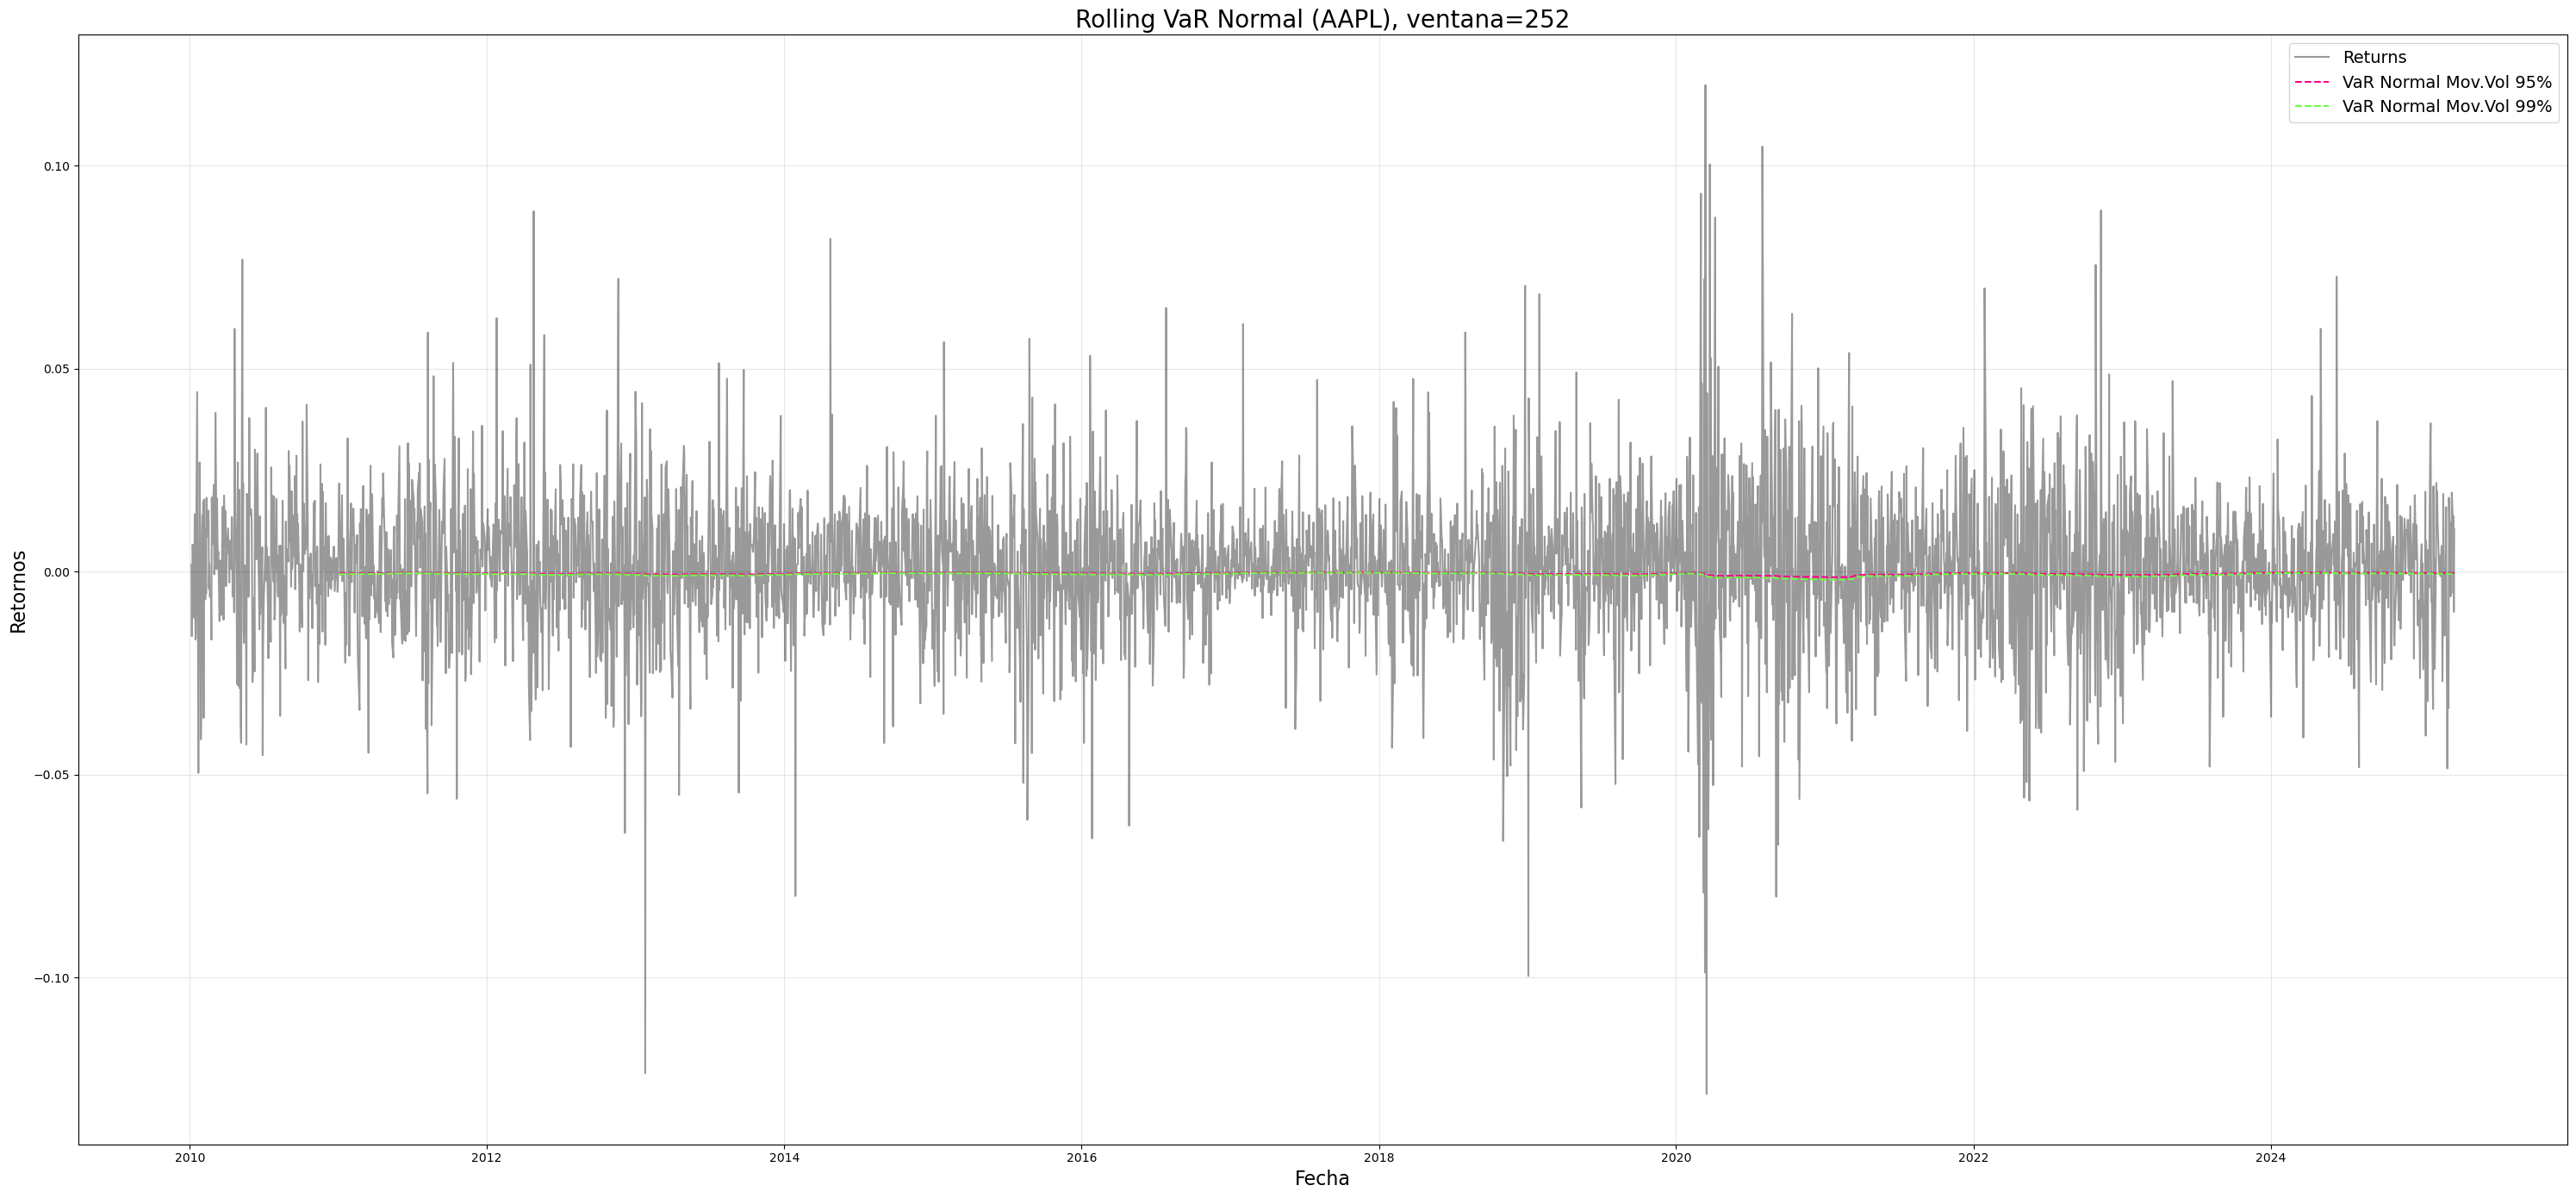

,VaR_Norm_95,VaR_Norm_99
Porcentaje de fallas,42.443226,41.973375
Número de fallas,1626,1608
Tipo de estimación,Mala estimación,Mala estimación


In [35]:
# f. FUNCIÓN VaR NORMAL
# Calculamos el VaR usando una distribución normal
def var_normal(returns, alpha):
    media = returns.mean()
    desviacion = returns.std()
    return norm.ppf(1 - alpha, loc=media, scale=desviacion)*desviacion

# Calculamos el VaR para cada nivel de confianza
for alpha in alphas:
    col_name = f'VaR_Norm_{int(alpha*100)}'  # Nombre de la nueva columna
    results[col_name] = results['returns'].rolling(window).apply(
        lambda x: var_normal(x, alpha), raw=False
    )

colors['VaR_Norm_95'] = '#ff008a'
colors['VaR_Norm_99'] = '#6cff3f'

# Gráfica de retornos y sus VaR
plt.figure(figsize=(30, 14))
plt.plot(results['returns'], label='Returns', color='black', alpha=0.4)

for alpha in alphas:
    a = int(alpha * 100)
    col_name = f'VaR_Norm_{a}'
    plt.plot(results[col_name],
             label=f'VaR Normal Mov.Vol {a}%',
             linestyle='--',
             color=colors[col_name])

plt.title(f'Rolling VaR Normal ({ticker}), ventana=252', fontsize=20)
plt.xlabel('Fecha', fontsize=16)
plt.ylabel('Retornos', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Contamos las fallas
sum_r_Norm = []
for col in [f'VaR_Norm_{int(a*100)}' for a in alphas]:
    violaciones = 0
    for i in range(len(results) - 1):
        if not np.isnan(results[col].iloc[i]):
            if results['returns'].iloc[i+1] < results[col].iloc[i]:
                violaciones += 1
    sum_r_Norm.append(violaciones)

# evaluamos si fue una buena o mala estimación
porc_Norm = (np.array(sum_r_Norm) / len(results)) * 100
estim_Norm = ['Buena estimación' if x < 2.5 else 'Mala estimación' for x in porc_Norm]


fallas_Norm = pd.DataFrame({
    'VaR_Norm_95': [porc_Norm[0], sum_r_Norm[0], estim_Norm[0]],
    'VaR_Norm_99': [porc_Norm[1], sum_r_Norm[1], estim_Norm[1]]
},
index=['Porcentaje de fallas','Número de fallas','Tipo de estimación'])

display(fallas_Norm)
